In [28]:
import ast
import importlib.util
import os

def extract_optimizer_info_from_file(file_path: str):
    # Load source code and parse AST
    with open(file_path, "r", encoding="utf-8") as f:
        code = f.read()
    tree = ast.parse(code)

    optimizer_name = None
    hyperparams = {}

    for node in ast.walk(tree):
        if isinstance(node, ast.ClassDef):
            optimizer_name = node.name

            for item in node.body:
                if isinstance(item, ast.FunctionDef) and item.name == "__init__":
                    args = item.args
                    param_names = [arg.arg for arg in args.args[2:]]
                    defaults = args.defaults
                    start = len(param_names) - len(defaults)

                    for i, default in enumerate(defaults):
                        param_name = param_names[start + i]
                        try:
                            value = ast.literal_eval(default)
                        except Exception:
                            value = ast.unparse(default) if hasattr(ast, 'unparse') else str(default)
                        hyperparams[param_name] = value
                # break

    # Dynamically import the module and get the class
    module_name = os.path.splitext(os.path.basename(file_path))[0]
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    print("optimizer name:", optimizer_name)
    optimizer_class = getattr(mod, optimizer_name)

    return {
        "optimizer_name": optimizer_name,
        "optimizer_class": optimizer_class,
        "hyperparameters": hyperparams
    }



# If run as a script
if __name__ == "__main__":

    file_path = "opt.py"
    info = extract_optimizer_info_from_file(file_path)
    print(info)


optimizer name: Muon
{'optimizer_name': 'Muon', 'optimizer_class': <class 'opt.Muon'>, 'hyperparameters': {'lr': 0.001, 'wd': 0.1, 'momentum': 0.95, 'nesterov': True, 'ns_steps': 5, 'adamw_betas': (0.95, 0.95), 'adamw_eps': 1e-08, 'embed_dim_threshold': 1000}}


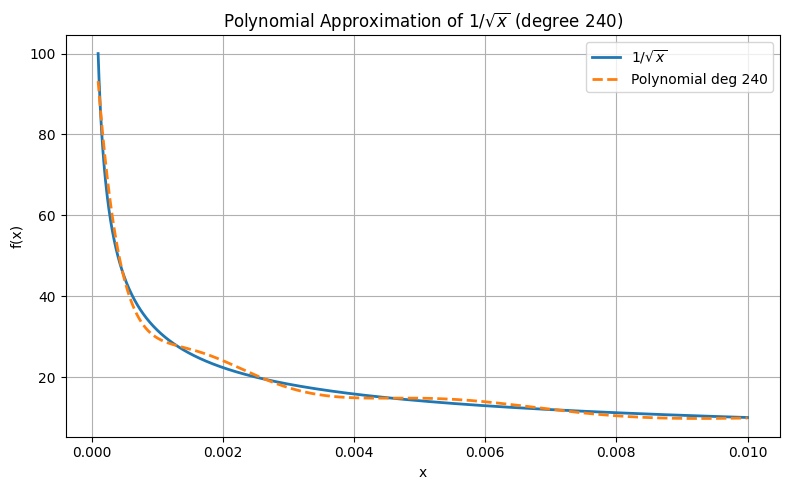

Polynomial Coefficients (lowest degree to highest):
a_0 = 116.9571381918
a_1 = -270580.3587854068
a_2 = 355633463.9676888585
a_3 = -263866266878.1403198242
a_4 = 123086182305518.7031250000
a_5 = -39230632132984656.0000000000
a_6 = 9084116840960897024.0000000000
a_7 = -1600571284450152546304.0000000000
a_8 = 222427352821233390452736.0000000000
a_9 = -25085522096244655287959552.0000000000
a_10 = 2349951236389589840690151424.0000000000
a_11 = -186393977759850577966263173120.0000000000
a_12 = 12721480340823665769215244107776.0000000000
a_13 = -757384758452417146625756676227072.0000000000
a_14 = 39798202554293689603827578276151296.0000000000
a_15 = -1864596267634700149290612120793120768.0000000000
a_16 = 78581286949321427144394673972716765184.0000000000
a_17 = -3002140797593981875230416814099503513600.0000000000
a_18 = 104685362178701627452120858092750260666368.0000000000
a_19 = -3352047445504514667171615498250638533328896.0000000000
a_20 = 99092303688780148997668237841636740340645888.00000

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial, Chebyshev

# Parameters
N = 240  # Degree of the polynomial
epsilon = 1e-4  # Avoid singularity at x = 0
num_points = 2000  # For plotting and error evaluation

# Target function
def f(x):
    return 1 / np.sqrt(x)

# Generate Chebyshev nodes mapped to [epsilon, 1]
cheb_nodes = np.cos(np.pi * (2*np.arange(1, N+2) - 1) / (2*(N+1)))
x_nodes = 0.5*(1 - cheb_nodes)*(1 - epsilon) + epsilon  # Map from [-1,1] to [epsilon,1]
y_nodes = f(x_nodes)

# Fit a polynomial using least squares
coeffs = np.polynomial.polynomial.Polynomial.fit(x_nodes, y_nodes, deg=N, domain=[epsilon,1]).convert().coef

# Create the polynomial object
p = Polynomial(coeffs)

# Evaluate for plotting and comparison
x_plot = np.linspace(epsilon, .01, num_points)
f_true = f(x_plot)
f_approx = p(x_plot)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x_plot, f_true, label=r'$1/\sqrt{x}$', linewidth=2)
plt.plot(x_plot, f_approx, '--', label=f'Polynomial deg {N}', linewidth=2)
plt.title(f'Polynomial Approximation of $1/\\sqrt{{x}}$ (degree {N})')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the coefficients
print("Polynomial Coefficients (lowest degree to highest):")
for i, c in enumerate(coeffs):
    print(f"a_{i} = {c:.10f}")


In [ ]:
import jax
import jax.numpy as jnp
from tqdm import tqdm


@jax.jit
def f(w, x):
    k, x1, x2 = w
    y = k
    for _ in range(7):
        y = x1 * y + x2 * x * y * y * y
    return (jnp.exp(-1e5*x) * (y * y * x - 1)**2).mean()


data = jnp.linspace(1e-9, 0.9, 10000)
f_grad = jax.grad(f)
w, u = jnp.array([1, 0.9, -1.1]), jnp.zeros(3)
progress_bar = tqdm(range(50000), desc='Training', unit='step')
for _ in progress_bar:
    u = 0.9 * u + f_grad(w, data)  # 动量加速
    w = w - 0.05 * u
    progress_bar.set_postfix({'loss': f(w, data)})
k, x1, x2 = w

Training:   0%|          | 1/50000 [00:01<14:35:52,  1.05s/step, loss=0.00010000233]

k: 1.959951
x1: 1.8158276
x2: -0.8147669


Text(0.5, 1.0, 'Plot of g(x) after optimization')

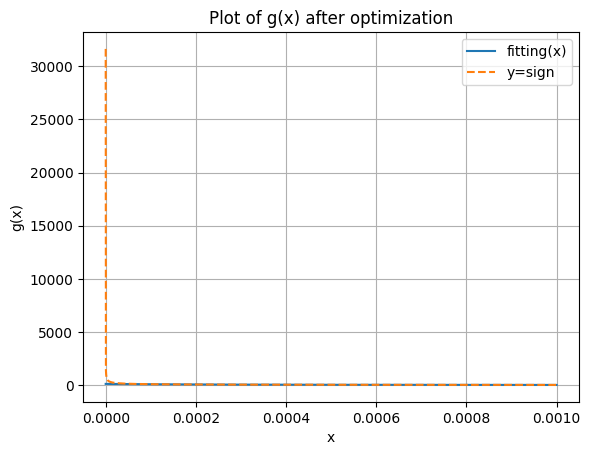

In [3]:
# plot the results
import matplotlib.pyplot as plt
print("k:", k)
print("x1:", x1)
print("x2:", x2)
def g(x, k, x1, x2):
    y = k
    for _ in range(7):
        y = x1 * y + x2 * x * y * y * y
    return y
data = jnp.linspace(1e-9, 0.001, 2000)
plt.plot(data, g(data, k, x1, x2), label='fitting(x)')
plt.plot(data, 1/jnp.sqrt(data), label='y=sign', linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('g(x)')
plt.title('Plot of g(x) after optimization')

In [3]:
import torch

a = torch.randn(10)
# take median
print(a.sort())
print(a.median())


torch.return_types.sort(
values=tensor([-1.8920, -1.5580, -1.2705, -1.2266, -0.8780, -0.7514, -0.3903,  0.0555,
         0.4161,  1.2785]),
indices=tensor([8, 3, 0, 7, 1, 4, 6, 5, 2, 9]))
tensor(-0.8780)
